## Бутстрап
Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва

В полученных подвыборках считаются статистики (среднее, медиана и т.п.)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import scipy.stats
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns
from scipy.stats import levene

from scipy import stats
from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
# считываем данные
df = pd.read_csv('../Lesson8/hw_bootstrap.csv', sep=';')

In [3]:
df

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control
...,...,...,...
995,996,1000,Treatment
996,997,1200,Treatment
997,998,1500,Treatment
998,999,2000,Treatment


In [4]:
# заменяем в значениях , на . чтобы перевести тип object в тип float
df['value'] = df['value'].str.replace(',', '.').astype(float)

**Применяя Т-критерий Стьюдента нужно помнить о:**

1. Дисперсии внутри наших групп должны быть примерно одинаковы (требование гомогенности дисперсий).
2. Особенно важный вопрос - это **требование к нормальности** данных обеих групп при применении t-теста.

In [6]:
# проверяем нормальность распределения данных в контрольной и тестовой группе
stats.shapiro(df[df['experimentVariant'] == 'Control'].value)

ShapiroResult(statistic=0.9959248900413513, pvalue=0.22416365146636963)

In [7]:
# видим, что данные по тесту shapiro отличаются от нормального распределения в группе treatment
stats.shapiro(df[df['experimentVariant'] == 'Treatment'].value)

ShapiroResult(statistic=0.07038933038711548, pvalue=1.0930128021733573e-43)

In [8]:
# поверим другим методом (normaltest)
# видим, что данные в тестовой группе распределены не нормально
pg.normality(data=df, dv='value', group='experimentVariant', method='normaltest')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,W,pval,normal
Control,2.943459,2.295282e-01,True
Treatment,929.515767,1.439514e-202,False


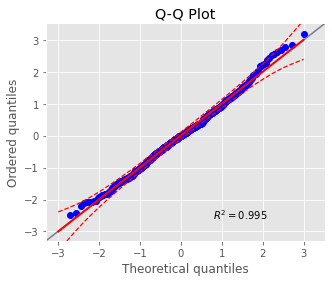

In [9]:
# смотрим распределение на qq plot, видим, что в контрольной группе распределение от нормального не отличается
pg.qqplot(df[df['experimentVariant'] == 'Control'].value)

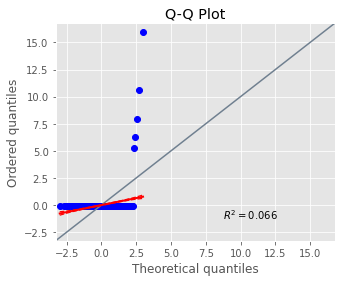

In [10]:
# а вот здесь видим что-то странное
pg.qqplot(df[df['experimentVariant'] == 'Treatment'].value)

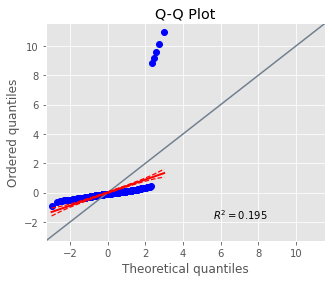

In [11]:
# пологарифмируем, но все равно что-то странное с выбросами
pg.qqplot(np.log(df[df['experimentVariant'] == 'Treatment'].value))

Text(0, 0.5, 'value')

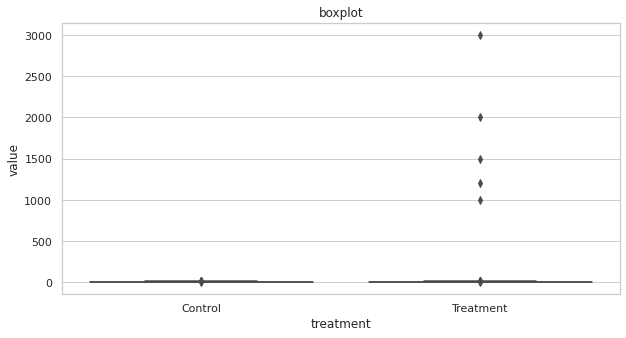

In [12]:
# выбросы существенные
sns.set(style='whitegrid', rc={'figure.figsize' : (10,5)}) 
sns.boxplot(data=df, x='experimentVariant', y='value')
plt.title('boxplot')
plt.xlabel('treatment')
plt.ylabel('value')

In [13]:
# В основном все значения тестовой группы меньше 13
df[df['experimentVariant'] == 'Treatment'].sort_values('value', ascending=True).query('value > 13')

,Unnamed: 0,value,experimentVariant
671,672,13.130346,Treatment
995,996,1000.000000,Treatment
996,997,1200.000000,Treatment
997,998,1500.000000,Treatment
998,999,2000.000000,Treatment
999,1000,3000.000000,Treatment


In [14]:
# проверим различие в дисперсиях групп
pg.homoscedasticity(data=df, dv='value', group='experimentVariant')

,W,pval,equal_var
levene,4.297837,0.038417,False


In [15]:
pg.welch_anova(data=df, dv='value', between='experimentVariant')

,Source,ddof1,ddof2,F,p-unc,np2
0,experimentVariant,1,499.027505,4.296923,0.038694,0.004287


In [16]:
# проверяем с помощью критерия Левена, различия в дисперсиях есть.
levene(df[df['experimentVariant'] == 'Treatment'].value, df[df['experimentVariant'] == 'Control'].value)

LeveneResult(statistic=4.297836608151554, pvalue=0.03841703888538016)

In [17]:
# Условия выполнения Т-теста не выполняются, но все равно выполним :)
# p<0,05. Тест показал, что отличия есть. Разница средних отклоняется от 0
# Чем больше значение отклонено от нуля (в большую или меньшую сторону),
# тем меньше вероятность видеть такие результаты в эксперименте, где между средними нет различий.
scipy.stats.ttest_ind(df[df['experimentVariant'] == 'Treatment'].value, \
                      df[df['experimentVariant'] == 'Control'].value)

Ttest_indResult(statistic=2.0729020485356604, pvalue=0.038437593613498765)

In [18]:
# с помощью критерия Тьюки
pg.pairwise_tukey(data=df, dv="value", between="experimentVariant")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Control,Treatment,10.026867,27.321499,-17.294633,8.343198,-2.072902,0.038439,-0.131003


Если распределение признака отличается от нормального, можно использовать непараметрический аналог – U-критерий Манна-Уитни. Он переводит все данные в ранговую шкалу (ранжирует показатели от 1 до последнего), после этого считает какой средний ранг оказался в первой группе и какой во второй.  
Этот критерий менее чувствителен к экстремальным отклонениям от нормальности и наличию выбросов.  

In [20]:
# согласно этому тесту у нас есть основания не отклонять нулевую гипотезу, т.к. p>005
# вероятность видеть такие результаты в эксперименте, где между средними нет различий высока (p-value = 0.86)
scipy.stats.mannwhitneyu(df[df['experimentVariant'] == 'Treatment'].value, \
                         df[df['experimentVariant'] == 'Control'].value)

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)

**Теперь воспользуемся бутстрапом средних.  
Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа**

In [23]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 2000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

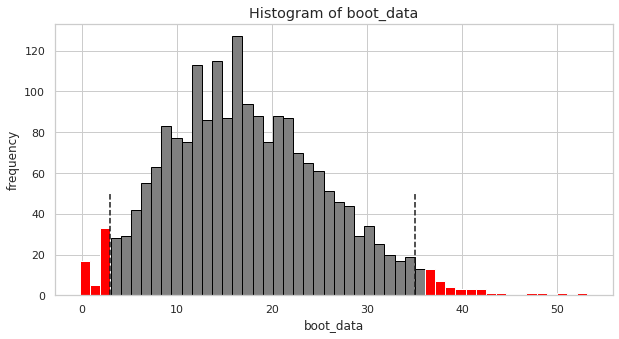

In [24]:
booted_data = get_bootstrap(
    df[df['experimentVariant'] == 'Treatment'].value, # числовые значения первой выборки
    df[df['experimentVariant'] == 'Control'].value # числовые значения второй выборки
)

In [25]:
# p значение < 0.05, значит отклоняем Н0
booted_data["p_value"]

0.03692985037554546

In [26]:
#  значение 0 не попадает в ДИ. Нулевая гипотеза не принимается
booted_data["quants"] # ДИ

,0
0.025,2.911403
0.975,35.043059


In [27]:
# если убрать выбросы, то Т критерий показывает, что разницы между средними нет
scipy.stats.ttest_ind(df[df['experimentVariant'] == 'Treatment'].query('value < 14').value, \
                      df[df['experimentVariant'] == 'Control'].value)

Ttest_indResult(statistic=-0.08299135107595523, pvalue=0.9338751428058142)

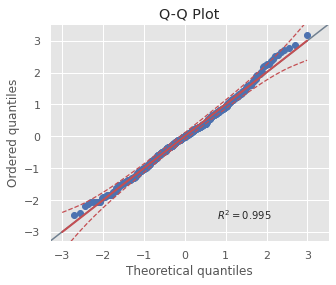

In [28]:
# qq plot показывает, что распределение treatment нормальное
pg.qqplot(df[df['experimentVariant'] == 'Treatment'].query('value < 14').value)

из-за несоблюдения условий (нормальность распределения и одинаковость дисперсий групп) для выполнения Т-теста оправданно использовать критерий Манна-Уитни.  
Хоть и критерий показывает, что различий между группами нет, метод бутстрап средних покахывает, что
Вероятность получить такие различия в эксперименте при справедливой нулевой гипотезе = 0.04.  
Ожидал, что бутстрап покажет большее значение p-value, что позволит не отклонять Н0. Предполагаю, что в данном случае метод бутстрапа средних лучше не применять, либо применить бутстрап медиан (см. ниже)

In [30]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 2000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # median() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

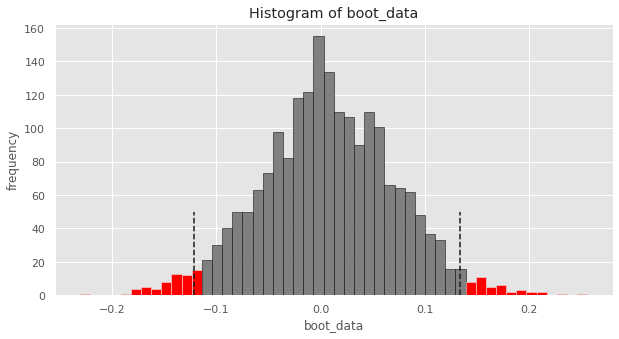

In [31]:
booted_data = get_bootstrap(
    df[df['experimentVariant'] == 'Treatment'].value, # числовые значения первой выборки
    df[df['experimentVariant'] == 'Control'].value # числовые значения второй выборки
)

In [32]:
# не отклоняем Н0
booted_data["p_value"]

0.9318456267341936

# Ответ


Верно следующее утверждение: Манн-Уитни и Бутстрап проверяют разные гипотезы. С помощью бутстрапа мы проверяем нулевую гипотезу о равенстве средних, а Манн-Уитни о равенстве распределений. Что значит равенство распределений? Это значит, что случайно выбранное значение из одной выборки может быть равновероятно больше или меньше случайного значения из другой выборки (иногда путают с равенством медиан, но на самом деле проверяется не только медиана). Также вы верно применили критерии и написали код


Про разное количество наблюдений в выборках: Манн-Уитни как и любой статистический оценщик не очень приветлив к дисбалансу. Это сказывается в первую очередь на мощности критерия – чем сильнее дисбаланс, тем реже критерий будет обнаруживать реальную разницу (эффект). Подробнее тут https://stats.stackexchange.com/questions/40342/mann-whitney-u-test-with-unequal-sample-sizes

## Итого
* Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение
* Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия
* Однако, тот же бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, так как p-value сильно больше 0.05, т.к. здесь проверяется другая гипотеза
* U-критерий Манна-Уитни так же не дал бы нам отклонить нулевую гипотезу. Оценки pvalue так же направлены как у бутстрапирования медианы